In [47]:
import torch
import torch.nn as nn
import os
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from torch.optim import Adam
import matplotlib.pyplot as plt
import math

torch.manual_seed(0)
np.random.seed(0)

In [48]:
################################################################
#  1d fourier layer
################################################################
class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv1d, self).__init__()

        """
        1D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul1d(self, input, weights):
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        return torch.einsum("bix,iox->box", input, weights)


######################### TO DO ####################################


    def forward(self, x):
        batchsize = x.shape[0]
        # x.shape == [batch_size, in_channels, number of grid points]
        # hint: use torch.fft library torch.fft.rfft
        # use DFT to approximate the fourier transform
        
        # Compute Fourier coefficients
        x_ft = torch.fft.rfft(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1) // 2 + 1, device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes1] = self.compl_mul1d(x_ft[:, :, :self.modes1], self.weights1)

        # Return to physical space
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return x


####################################################################


class FNO1d(nn.Module):
    def __init__(self, modes, width):
        super(FNO1d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .

        input: the solution of the initial condition and location (a(x), x)
        input shape: (batchsize, x=s, c=2)
        output: the solution of a later timestep
        output shape: (batchsize, x=s, c=1)
        """

        self.modes1 = modes
        self.width = width
        self.padding = 1  # pad the domain if input is non-periodic
        self.linear_p = nn.Linear(2, self.width)  # input channel is 2: (u0(x), x)

        self.spect1 = SpectralConv1d(self.width, self.width, self.modes1)
        self.spect2 = SpectralConv1d(self.width, self.width, self.modes1)
        self.spect3 = SpectralConv1d(self.width, self.width, self.modes1)
        self.lin0 = nn.Conv1d(self.width, self.width, 1)
        self.lin1 = nn.Conv1d(self.width, self.width, 1)
        self.lin2 = nn.Conv1d(self.width, self.width, 1)

        self.linear_q = nn.Linear(self.width, 32)
        self.output_layer = nn.Linear(32, 1)

        self.activation = torch.nn.Tanh()

    def fourier_layer(self, x, spectral_layer, conv_layer):
        return self.activation(spectral_layer(x) + conv_layer(x))

    def linear_layer(self, x, linear_transformation):
        return self.activation(linear_transformation(x))

    def forward(self, x):
        # grid = self.get_grid(x.shape, x.device)
        # x = torch.cat((x, grid), dim=-1)
        x = self.linear_p(x)
        x = x.permute(0, 2, 1)
        x = F.pad(x, [0, self.padding])  # pad the domain if input is non-periodic

        x = self.fourier_layer(x, self.spect1, self.lin0)
        x = self.fourier_layer(x, self.spect2, self.lin1)
        x = self.fourier_layer(x, self.spect3, self.lin2)

        x = x[..., :-self.padding]  # pad the domain if input is non-periodic
        x = x.permute(0, 2, 1)
        x = self.linear_layer(x, self.linear_q)
        x = self.output_layer(x)
        return x

torch.Size([245])


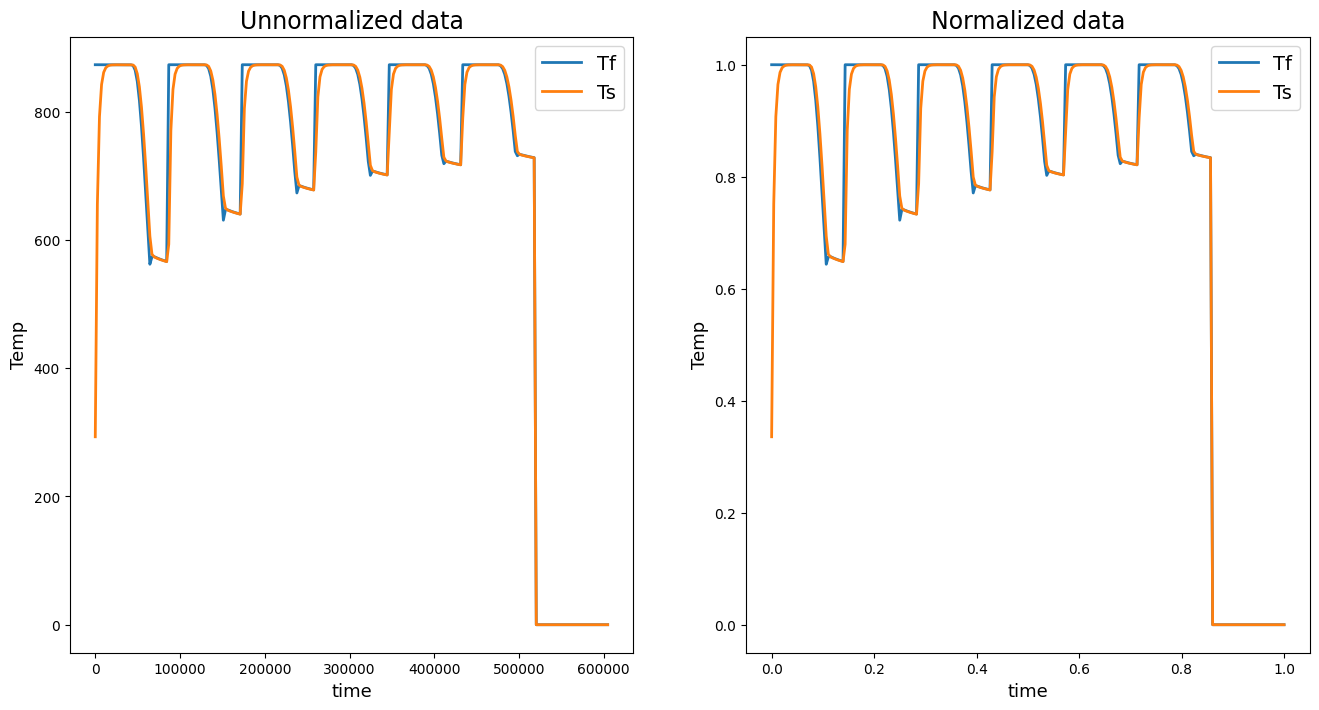

In [61]:
file_training = "TrainingData.txt"
file_sub = "TestingData.txt"


def normalize_pytorch(tensor):
    min_vals, _ = torch.min(tensor, dim=0)
    max_vals, _ = torch.max(tensor, dim=0)
    normalized_tensor = (tensor - min_vals) / (max_vals - min_vals)
    return normalized_tensor

def un_normalize(tensor1, tensor2):
    min_vals, _ = torch.min(tensor1, dim=0)
    max_vals, _ = torch.max(tensor1, dim=0)
    unormalized_tensor = (max_vals - min_vals) * tensor2 + min_vals
    return unormalized_tensor

data_training = np.genfromtxt(file_training, delimiter=",", skip_header=1)
data_t_sub = np.genfromtxt(file_sub, delimiter=",", skip_header=1)

dt = data_t_sub[-1] - data_t_sub[-2]
data_t_sub = np.append(data_t_sub, data_t_sub[-1] + dt)



data_t_sub = torch.tensor(data_t_sub, dtype=torch.float32)
zeros = torch.zeros_like(data_t_sub)

data_t = torch.cat([torch.tensor(data_training[:,0], dtype=torch.float32), data_t_sub], dim=0)
data_Tf = torch.cat([torch.tensor(data_training[:,1], dtype=torch.float32), zeros], dim=0)
data_Ts = torch.cat([torch.tensor(data_training[:,2], dtype=torch.float32), zeros], dim=0)

data_t_norm = normalize_pytorch(data_t)
data_Tf_norm = normalize_pytorch(data_Tf)
data_Ts_norm = normalize_pytorch(data_Ts)

data_lin = torch.linspace(-1, 1, data_Tf_norm.shape[0])


# Plot the data
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# unnormalized data
axs[0].plot(data_t, data_Tf, label='Tf', linewidth=2)
axs[0].plot(data_t, data_Ts, label='Ts', linewidth=2)
axs[0].set_xlabel('time', size=13)
axs[0].set_ylabel('Temp', size=13)
axs[0].legend(fontsize=14)
axs[0].set_title('Unnormalized data', size=17)

# normalized data
axs[1].plot(data_t_norm, data_Tf_norm, label='Tf', linewidth=2)
axs[1].plot(data_t_norm, data_Ts_norm, label='Ts', linewidth=2)
axs[1].set_xlabel('time', size=13)
axs[1].set_ylabel('Temp', size=13)
axs[1].legend(fontsize=14)
axs[1].set_title('Normalized data', size=17)
 

print(data_t.shape)

In [62]:
n_points = 35
batch_size = 2
shift = 35


print(data_t_norm.shape[0]-n_points)
print((data_t_norm.shape[0]-n_points)/shift)

def divisorGenerator(n):
    large_divisors = []
    for i in range(1, int(math.sqrt(n) + 1)):
        if n % i == 0:
            yield i
            if i*i != n:
                large_divisors.append(n / i)
    for divisor in reversed(large_divisors):
        yield divisor

print(list(divisorGenerator(data_t_norm.shape[0]-n_points)))

210
6.0
[1, 2, 3, 5, 6, 7, 10, 14, 15.0, 21.0, 30.0, 35.0, 42.0, 70.0, 105.0, 210.0]


---------------------------------
new_tensor_t.shape:	 torch.Size([245])
new_tensor_Tf.shape:	 torch.Size([245])
new_tensor_Tf.shape:	 torch.Size([7, 35, 2])
1
---------------------------------
input_train_Tf.shape:	 torch.Size([4, 35, 2])
output_train_Tf.shape:	 torch.Size([4, 35])
---------------------------------

input_test_Tf.shape:	 torch.Size([1, 35, 2])
output_test_Tf.shape:	 torch.Size([1, 35])


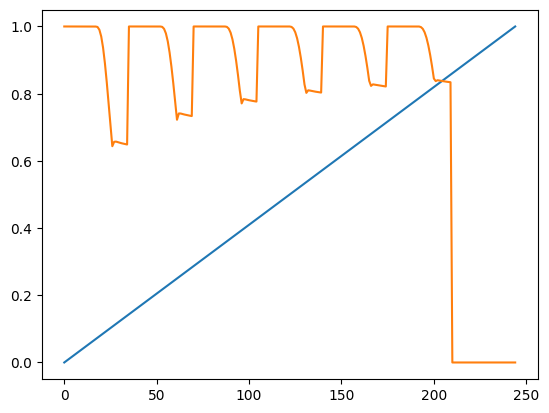

In [63]:

new_tensor_t = data_t_norm[:n_points]
new_tensor_Tf = data_Tf_norm[:n_points]
new_tensor_Ts = data_Ts_norm[:n_points]

new_tensor_lin = data_lin[:n_points]

for i in range(int((data_t_norm.shape[0]-n_points)/shift)):
    new_tensor_t = torch.cat([new_tensor_t, data_t_norm[(i+1)*shift:n_points+(i+1)*shift]], dim=0)
    new_tensor_Tf = torch.cat([new_tensor_Tf, data_Tf_norm[(i+1)*shift:n_points+(i+1)*shift]], dim=0)
    new_tensor_Ts = torch.cat([new_tensor_Ts, data_Ts_norm[(i+1)*shift:n_points+(i+1)*shift]], dim=0)
    new_tensor_lin = torch.cat([new_tensor_lin, data_lin[(i+1)*shift:n_points+(i+1)*shift]], dim=0)

plt.plot(range(int(new_tensor_t.shape[0])), new_tensor_t.detach() )
plt.plot(range(int(new_tensor_Tf.shape[0])), new_tensor_Tf.detach() )
print("---------------------------------")
print("new_tensor_t.shape:\t", new_tensor_t.shape)
print("new_tensor_Tf.shape:\t", new_tensor_Tf.shape)

lin_space = 0

if lin_space == 1:
    input_Tf = torch.stack([new_tensor_lin, new_tensor_t], dim=1).reshape(-1, n_points, 2)
    input_Ts = torch.stack([new_tensor_lin, new_tensor_t], dim=1).reshape(-1, n_points, 2)
elif lin_space ==0:
    input_Tf = torch.stack([new_tensor_Tf, new_tensor_t], dim=1).reshape(-1, n_points, 2)
    input_Ts = torch.stack([new_tensor_Ts, new_tensor_t], dim=1).reshape(-1, n_points, 2)

print("new_tensor_Tf.shape:\t", input_Tf.shape)

index = 0
check = 1
for i in range(input_Tf.shape[0]):
    
    if i*shift >= 35 and check == 1:
        index = i
        break

print(index)

with_test = 1

if with_test == 1:
    input_train_Tf = input_Tf[:-(2*index + 1), :]
    input_test_Tf = input_Tf[-(2*index+1):-(index+1), :]

    output_train_Tf = new_tensor_Tf.reshape(-1, n_points)[1:-2*index, :]
    output_test_Tf = new_tensor_Tf.reshape(-1, n_points)[-(2*index):-index]

    training_set_Tf = DataLoader(TensorDataset(input_train_Tf, output_train_Tf), batch_size=batch_size, shuffle=True)
    testing_set_Tf = DataLoader(TensorDataset(input_test_Tf, output_test_Tf), batch_size=batch_size, shuffle=True)

    input_train_Ts = input_Ts[:-(2*index + 1), :]
    input_test_Ts = input_Ts[-(2*index+1):-(index+1), :]

    output_train_Ts = new_tensor_Ts.reshape(-1, n_points)[1:-2*index, :]
    output_test_Ts = new_tensor_Ts.reshape(-1, n_points)[-(2*index):-index]

    training_set_Ts = DataLoader(TensorDataset(input_train_Ts, output_train_Ts), batch_size=batch_size, shuffle=True)
    testing_set_Ts = DataLoader(TensorDataset(input_test_Ts, output_test_Ts), batch_size=batch_size, shuffle=True)
    print("---------------------------------")
    print("input_train_Tf.shape:\t", input_train_Tf.shape)
    print("output_train_Tf.shape:\t", output_train_Tf.shape)

    print("---------------------------------")
    print("\ninput_test_Tf.shape:\t", input_test_Tf.shape)
    print("output_test_Tf.shape:\t", output_test_Tf.shape)

elif with_test == 0:
    input_train_Tf = input_Tf[:-(index + 1), :]
    output_train_Tf = new_tensor_Tf.reshape(-1, n_points)[1:-index, :]
    training_set_Tf = DataLoader(TensorDataset(input_train_Tf, output_train_Tf), batch_size=batch_size, shuffle=True)

    input_train_Ts = input_Ts[:-(index + 1), :]
    output_train_Ts = new_tensor_Ts.reshape(-1, n_points)[1:-index, :]
    training_set_Ts = DataLoader(TensorDataset(input_train_Ts, output_train_Ts), batch_size=batch_size, shuffle=True)


    print("---------------------------------")
    print("input_train_Tf.shape:\t", input_train_Tf.shape)
    print("output_train_Tf.shape:\t", output_train_Tf.shape)



In [52]:
for step, (input_batch, output_batch) in enumerate(training_set_Tf):
    if step == 0:
        print('input_batch.shape: ', input_batch.shape)
        print('output_batch.shape: ', output_batch.shape)

input_batch.shape:  torch.Size([2, 35, 2])
output_batch.shape:  torch.Size([2, 35])


In [53]:
learning_rate = 0.001

epochs = 500

step_size = 50
gamma = 0.5

modes = n_points//2

width = 128

# model

fno_Tf = FNO1d(modes, width)
fno_Ts = FNO1d(modes, width)

In [54]:
# Train the Tf FNO
optimizerTf = Adam(fno_Tf.parameters(), lr=learning_rate, weight_decay=1e-5)
schedulerTf = torch.optim.lr_scheduler.StepLR(optimizerTf, step_size=step_size, gamma=gamma)

optimizerTs = Adam(fno_Ts.parameters(), lr=learning_rate, weight_decay=1e-5)
schedulerTs = torch.optim.lr_scheduler.StepLR(optimizerTs, step_size=step_size, gamma=gamma)


l = torch.nn.MSELoss()
freq_print = 1
for epoch in range(epochs):
    train_mse = 0.0
    for step, (input_batch, output_batch) in enumerate(training_set_Tf):
        optimizerTf.zero_grad()
        output_pred_batch = fno_Tf(input_batch).squeeze(2)
        loss_f = l(output_pred_batch, output_batch)
        loss_f.backward()
        optimizerTf.step()
        train_mse += loss_f.item()
    train_mse /= len(training_set_Tf)

    schedulerTf.step()

    if with_test == 1:
        with torch.no_grad():
            fno_Tf.eval()
            test_relative_l2 = 0.0
            for step, (input_batch, output_batch) in enumerate(testing_set_Tf):
                output_pred_batch = fno_Tf(input_batch).squeeze(2)
                loss_f = (torch.mean((output_pred_batch - output_batch) ** 2) / torch.mean(output_batch ** 2)) ** 0.5 * 100
                test_relative_l2 += loss_f.item()
            test_relative_l2 /= len(testing_set_Tf)

        if epoch % freq_print == 0: print("######### Epoch:", epoch, " ######### Train Loss:", np.log10(train_mse), " ######### Relative L2 Test Norm:", test_relative_l2)
    
    elif with_test == 0:
        if epoch % freq_print == 0: print("######### Epoch:", epoch, " ######### Train Loss:", np.log10(train_mse))

for epoch in range(epochs):
    train_mse = 0.0
    for step, (input_batch, output_batch) in enumerate(training_set_Ts):
        optimizerTs.zero_grad()
        output_pred_batch = fno_Ts(input_batch).squeeze(2)
        loss_f = l(output_pred_batch, output_batch)
        loss_f.backward()
        optimizerTs.step()
        train_mse += loss_f.item()
    train_mse /= len(training_set_Ts)

    schedulerTf.step()

    if with_test == 1:
        with torch.no_grad():
            fno_Tf.eval()
            test_relative_l2 = 0.0
            for step, (input_batch, output_batch) in enumerate(testing_set_Ts):
                output_pred_batch = fno_Ts(input_batch).squeeze(2)
                loss_f = (torch.mean((output_pred_batch - output_batch) ** 2) / torch.mean(output_batch ** 2)) ** 0.5 * 100
                test_relative_l2 += loss_f.item()
            test_relative_l2 /= len(testing_set_Ts)

        if epoch % freq_print == 0: print("######### Epoch:", epoch, " ######### Train Loss:", np.log10(train_mse), " ######### Relative L2 Test Norm:", test_relative_l2)
    
    elif with_test == 0:
        if epoch % freq_print == 0: print("######### Epoch:", epoch, " ######### Train Loss:", np.log10(train_mse))




######### Epoch: 0  ######### Train Loss: -0.13700360722321347  ######### Relative L2 Test Norm: 20.639541625976562
######### Epoch: 1  ######### Train Loss: -1.0016578536637837  ######### Relative L2 Test Norm: 29.826000213623047
######### Epoch: 2  ######### Train Loss: -1.2880375609218844  ######### Relative L2 Test Norm: 23.95790386199951
######### Epoch: 3  ######### Train Loss: -1.2092163383497438  ######### Relative L2 Test Norm: 20.48158359527588
######### Epoch: 4  ######### Train Loss: -1.6400561154984568  ######### Relative L2 Test Norm: 11.187849521636963
######### Epoch: 5  ######### Train Loss: -1.5588172310938455  ######### Relative L2 Test Norm: 12.04420804977417
######### Epoch: 6  ######### Train Loss: -1.734419431192264  ######### Relative L2 Test Norm: 9.41061019897461
######### Epoch: 7  ######### Train Loss: -1.8177687340049418  ######### Relative L2 Test Norm: 13.614861011505127
######### Epoch: 8  ######### Train Loss: -1.7709251470759704  ######### Relative L2 

Relative L2 error:  48.24900817871094
Relative L2 error:  36.01040267944336
Relative L2 error:  25.7299861907959


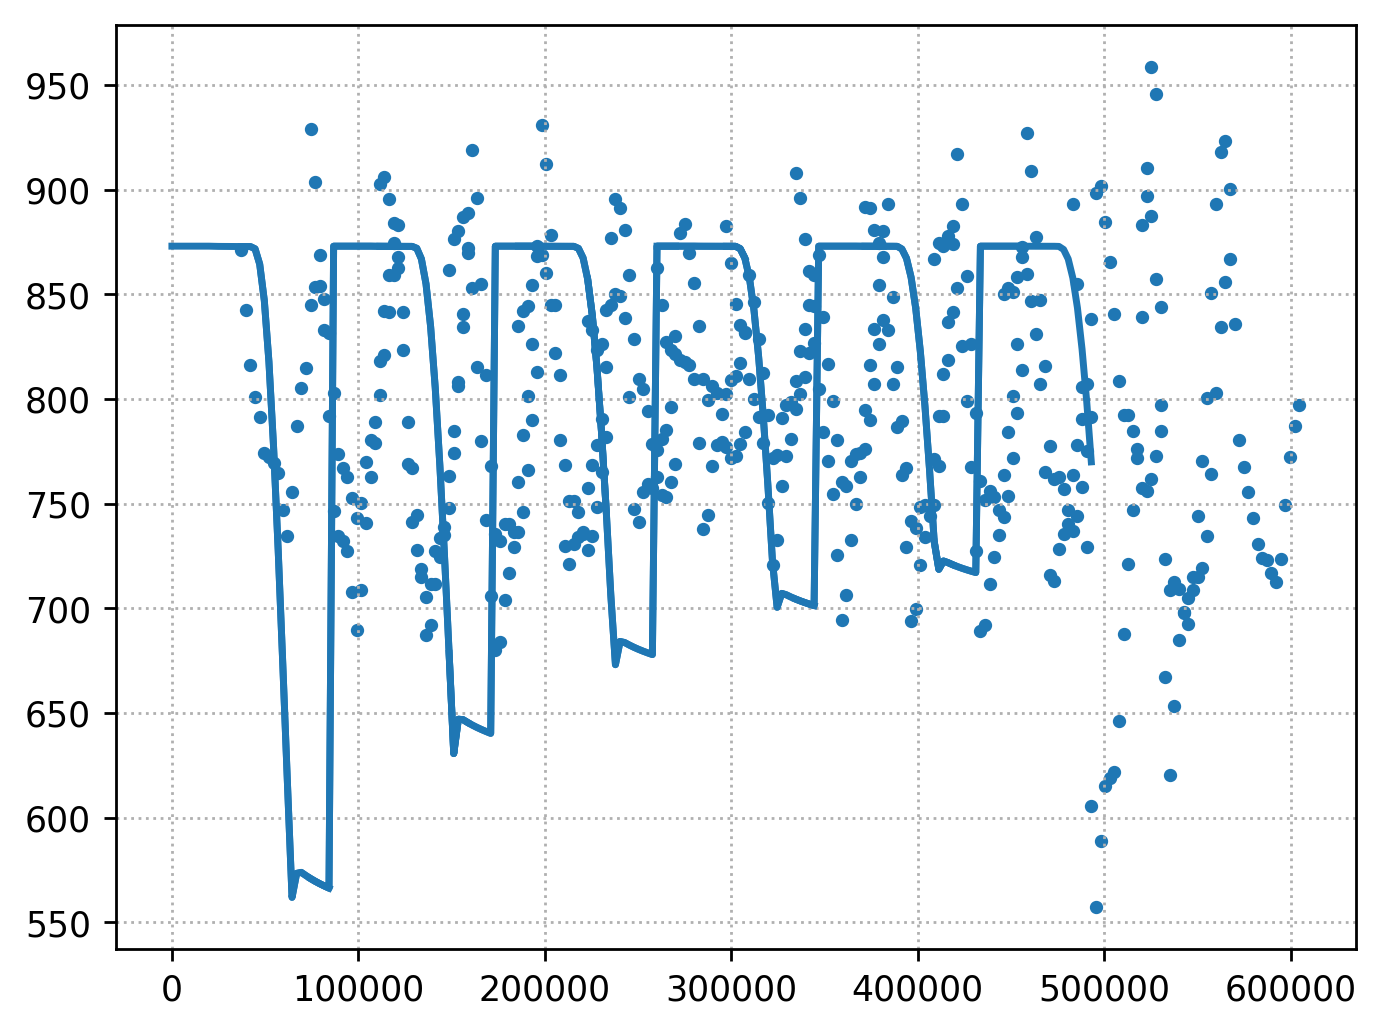

Relative L2 error:  50.543914794921875
Relative L2 error:  37.85865783691406
Relative L2 error:  27.174800872802734


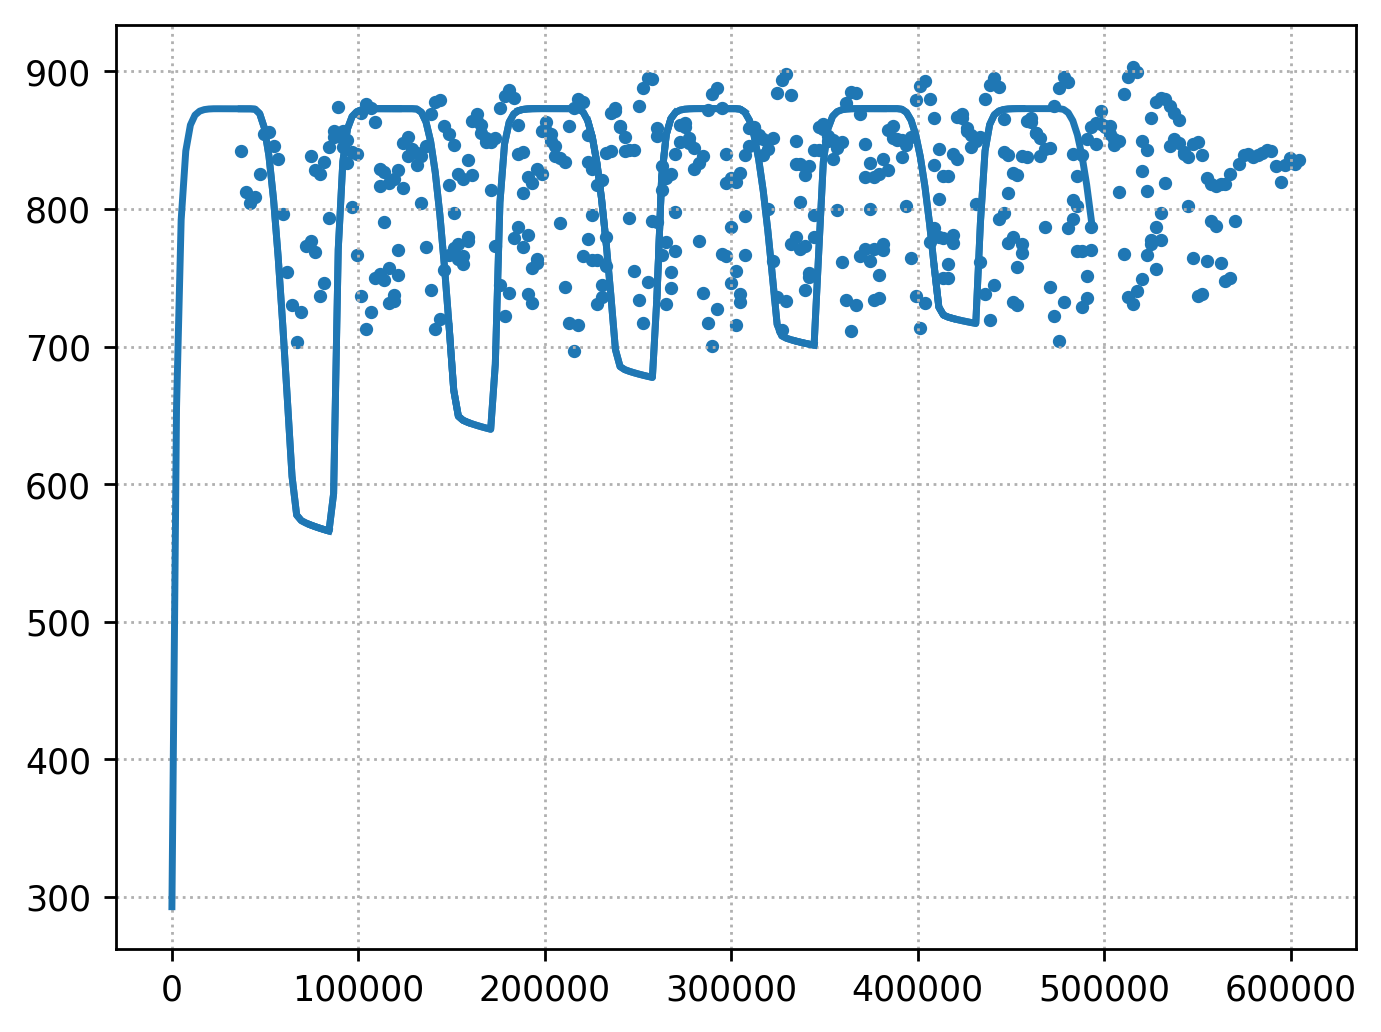

In [55]:
input_Tf = torch.stack([new_tensor_Tf, new_tensor_t], dim=1).reshape(-1, n_points, 2)
input_Ts = torch.stack([new_tensor_Ts, new_tensor_t], dim=1).reshape(-1, n_points, 2)

plt.figure(dpi=250)
plt.grid(True, which="both", ls=":")

for i in range(input_Tf[:-1,:].shape[0]):
    
    if i < input_Tf[:-index,:].shape[0]:
 
        input_time = input_Tf[i,:][:,1].detach()
        input_time = un_normalize(data_t, input_time)
        
        output_function = input_Tf[i, :][:,0].unsqueeze(0)
        output_temp = un_normalize(data_Tf, output_function).reshape(-1)
        plt.plot(input_time.detach(), output_temp.detach(), label="True Solution", c="C0", lw=2)
    
    if i >= input_Tf[:-(2*index+1),:].shape[0] and i < input_Tf[:-(index+1),:].shape[0]:
        
        input_function_test = input_Tf[i, :].unsqueeze(0)
        output_temp_pred = fno_Tf(input_function_test)
        output_temp_pred = un_normalize(data_Tf, output_temp_pred)

        input_time = input_Tf[i+1,:][:,1]
        input_time = un_normalize(data_t, input_time)

        output_true = input_Tf[i+1,:][:,1]
        output_true = un_normalize(data_Tf, output_true)

        err = (torch.mean(abs(output_true.detach().reshape(-1, ) - output_temp_pred.detach().reshape(-1, )) ** 2) / torch.mean(abs(output_true.detach()) ** 2)) ** (1 / 2) * 100
        print("Relative L2 error: ", err.item())


    input_function_test = input_Tf[i, :].unsqueeze(0)
    output_temp_pred = fno_Tf(input_function_test)
    output_temp_pred = un_normalize(data_Tf, output_temp_pred)
    input_time = input_Tf[i+1,:][:,1]
    input_time = un_normalize(data_t, input_time)
    plt.scatter(input_time.detach(), output_temp_pred.detach(), label="Approximate Solution", s=8, c="C0")

plt.show()


plt.figure(dpi=250)
plt.grid(True, which="both", ls=":")

for i in range(input_Ts[:-1,:].shape[0]):
    
    if i < input_Ts[:-index,:].shape[0]:
 
        input_time = input_Ts[i,:][:,1].detach()
        input_time = un_normalize(data_t, input_time)
        
        output_function = input_Ts[i, :][:,0].unsqueeze(0)
        output_temp = un_normalize(data_Ts, output_function).reshape(-1)
        
        plt.plot(input_time.detach(), output_temp.detach(), label="True Solution", c="C0", lw=2)
    
    if i >= input_Ts[:-(2*index+1),:].shape[0] and i < input_Ts[:-(index+1),:].shape[0]:
        
        input_function_test = input_Ts[i, :].unsqueeze(0)
        output_function_test_pred = fno_Ts(input_function_test)
        output_temp_pred = un_normalize(data_Ts, output_function_test_pred)

        input_time = input_Ts[i+1,:][:,1]
        input_time = un_normalize(data_t, input_time)

        output_true = input_Ts[i+1,:][:,1]
        output_true = un_normalize(data_Tf, output_true)

        err = (torch.mean(abs(output_true.detach().reshape(-1, ) - output_temp_pred.detach().reshape(-1, )) ** 2) / torch.mean(abs(output_true.detach()) ** 2)) ** (1 / 2) * 100
        print("Relative L2 error: ", err.item())


    input_function_test = input_Ts[i, :].unsqueeze(0)
    output_function_test_pred = fno_Ts(input_function_test)
    output_temp_pred = un_normalize(data_Ts, output_function_test_pred)
    input_time = input_Ts[i+1,:][:,1]
    input_time = un_normalize(data_t, input_time)
    plt.scatter(input_time.detach(), output_temp_pred.detach(), label="Approximate Solution", s=8, c="C0")


In [56]:

Tf = fno_Tf(input_Tf[-index, :].unsqueeze(0)).squeeze(0)
Ts = fno_Ts(input_Ts[-index, :].unsqueeze(0)).squeeze(0)
outputs_Tf = []
outputs_Ts = []

for i in range(34):
    outputs_Tf.append(Tf[i].item())
    outputs_Ts.append(Ts[i].item())
    

outputs_Tf = np.array(outputs_Tf)
outputs_Ts = np.array(outputs_Ts)


data_t_sub = np.genfromtxt(file_sub, delimiter=",", skip_header=1)

combined_array = np.column_stack((data_t_sub, outputs_Tf, outputs_Ts))

print(combined_array)

np.savetxt("submissionTask3_LUCA_SACCHI_new.txt", combined_array, delimiter=",", header="t,x,ts")




[[5.20392600e+05 1.02316082e+00 9.24126327e-01]
 [5.22870660e+05 9.79111075e-01 9.43931520e-01]
 [5.25348720e+05 9.22989607e-01 9.61085677e-01]
 [5.27826780e+05 8.35305154e-01 9.74940479e-01]
 [5.30304840e+05 6.93941951e-01 9.84392047e-01]
 [5.32782900e+05 6.38572812e-01 9.87963140e-01]
 [5.35260960e+05 6.74265504e-01 9.87170756e-01]
 [5.37739020e+05 7.04381824e-01 9.85785663e-01]
 [5.40217080e+05 7.09022343e-01 9.85500038e-01]
 [5.42695140e+05 7.12232172e-01 9.74687874e-01]
 [5.45173200e+05 7.39907146e-01 9.30400848e-01]
 [5.47651260e+05 7.88028717e-01 8.78842056e-01]
 [5.50129320e+05 8.26236308e-01 8.43141615e-01]
 [5.52607380e+05 8.55619311e-01 8.37012887e-01]
 [5.55085440e+05 8.89186263e-01 8.48414600e-01]
 [5.57563500e+05 9.61247087e-01 8.58496189e-01]
 [5.60041560e+05 1.04293287e+00 8.77920270e-01]
 [5.62519620e+05 1.09820056e+00 8.87404621e-01]
 [5.64997680e+05 1.08315265e+00 9.01730597e-01]
 [5.67475740e+05 9.66868281e-01 9.13349628e-01]
 [5.69953800e+05 7.64198303e-01 9.384641